In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Environment Setup
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, f1_score
import os
import json

print(f"TensorFlow: {tf.__version__}")
print(f"GPU: {tf.config.list_physical_devices('GPU')}")

# Enable mixed precision for faster training
keras.mixed_precision.set_global_policy('mixed_float16')

TensorFlow: 2.19.0
GPU: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [ ]:
# Extract dataset from Google Drive
!unzip -q /content/drive/MyDrive/Minor-project-1/PlantVillage_split.zip -d /content/

# Configuration
BASE_PATH = '/content/PlantVillage_split'
TRAIN_DIR = f'{BASE_PATH}/Training'
VAL_DIR = f'{BASE_PATH}/Validation'
TEST_DIR = f'{BASE_PATH}/Testing'

IMG_SIZE = 224
BATCH_SIZE = 32
EPOCHS = 100
INITIAL_LR = 0.001
MIN_LR = 1e-7

# Verify dataset exists
assert os.path.exists(TRAIN_DIR), f"Training directory not found: {TRAIN_DIR}"
assert os.path.exists(VAL_DIR), f"Validation directory not found: {VAL_DIR}"
assert os.path.exists(TEST_DIR), f"Test directory not found: {TEST_DIR}"

print("Dataset verified successfully")

Dataset verified successfully


In [ ]:
# Data Loading
train_ds = keras.utils.image_dataset_from_directory(
    TRAIN_DIR,
    seed=42,
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    label_mode='int'
)

val_ds = keras.utils.image_dataset_from_directory(
    VAL_DIR,
    seed=42,
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    label_mode='int'
)

test_ds = keras.utils.image_dataset_from_directory(
    TEST_DIR,
    seed=42,
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    label_mode='int'
)

CLASS_NAMES = train_ds.class_names
NUM_CLASSES = len(CLASS_NAMES)

# Calculate class weights with stronger penalty for Late Blight
import collections
class_counts = collections.Counter()
for _, labels in train_ds:
    class_counts.update(labels.numpy())

total_samples = sum(class_counts.values())
class_weights = {i: total_samples / (NUM_CLASSES * class_counts[i]) for i in range(NUM_CLASSES)}

# Boost Late Blight weight by 30%
late_blight_idx = CLASS_NAMES.index('Potato___Late_blight')
class_weights[late_blight_idx] *= 1.3

print(f"Classes: {CLASS_NAMES}")
print(f"Class distribution: {dict(class_counts)}")
print(f"Class weights: {class_weights}")
print(f"Training batches: {len(train_ds)}")
print(f"Validation batches: {len(val_ds)}")
print(f"Test batches: {len(test_ds)}")

Found 2100 files belonging to 3 classes.
Found 450 files belonging to 3 classes.
Found 450 files belonging to 3 classes.
Classes: ['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']
Class distribution: {np.int32(0): 700, np.int32(2): 700, np.int32(1): 700}
Class weights: {0: 1.0, 1: 1.3, 2: 1.0}
Training batches: 66
Validation batches: 15
Test batches: 15


In [ ]:
# Data Augmentation - Conservative for disease-specific features
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.RandomContrast(0.1),
    layers.RandomBrightness(0.05)
], name="augmentation")

normalization = layers.Rescaling(1./255, name="normalization")

# Pipeline Optimization
AUTOTUNE = tf.data.AUTOTUNE

def prepare_dataset(ds, shuffle=False, augment=False):
    ds = ds.map(lambda x, y: (normalization(x), y), num_parallel_calls=AUTOTUNE)
    ds = ds.cache()
    if shuffle:
        ds = ds.shuffle(1000)
    if augment:
        ds = ds.map(lambda x, y: (data_augmentation(x, training=True), y), num_parallel_calls=AUTOTUNE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

train_ds = prepare_dataset(train_ds, shuffle=True, augment=True)
val_ds = prepare_dataset(val_ds, shuffle=False, augment=False)
test_ds = prepare_dataset(test_ds, shuffle=False, augment=False)

In [ ]:
# Transfer Learning - MobileNetV2
base_model = keras.applications.MobileNetV2(
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
    include_top=False,
    weights='imagenet'
)
base_model.trainable = False

inputs = keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
x = base_model(inputs, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.4)(x)
x = layers.Dense(256, activation='relu', kernel_regularizer=keras.regularizers.l2(0.01))(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(128, activation='relu', kernel_regularizer=keras.regularizers.l2(0.01))(x)
x = layers.Dropout(0.2)(x)
outputs = layers.Dense(NUM_CLASSES, activation='softmax', dtype='float32')(x)

model = keras.Model(inputs, outputs, name='potato_mobilenetv2')
model.summary()

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "potato_mobilenetv2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 1280)           │         5,120 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,625,347 (10.01 MB)

 Trainable params: 364,291 (1.39 MB)

 Non-trainable params: 2,261,056 (8.63 MB)

In [ ]:
# Phase 1: Train classifier head only
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=INITIAL_LR),
    loss=keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

callbacks_phase1 = [
    keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=15,
        restore_best_weights=True,
        mode='min',
        verbose=1
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=4,
        min_lr=MIN_LR,
        mode='min',
        verbose=1
    ),
    keras.callbacks.ModelCheckpoint(
        '/content/drive/MyDrive/Minor-project-1/checkpoint_phase1.keras',
        monitor='val_loss',
        save_best_only=True,
        mode='min',
        verbose=1
    )
]

In [ ]:
# Phase 1: Train with frozen base
print("Phase 1: Training classification head (base frozen)")
history_phase1 = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=30,
    class_weight=class_weights,
    callbacks=callbacks_phase1,
    verbose=1
)

# Phase 2: Fine-tune top layers
print("\nPhase 2: Fine-tuning (unfreezing top layers)")
base_model.trainable = True
for layer in base_model.layers[:-40]:
    layer.trainable = False

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=INITIAL_LR/20),
    loss=keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

callbacks_phase2 = [
    keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=25,
        restore_best_weights=True,
        mode='min',
        verbose=1
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.3,
        patience=6,
        min_lr=MIN_LR,
        mode='min',
        verbose=1
    ),
    keras.callbacks.ModelCheckpoint(
        '/content/drive/MyDrive/Minor-project-1/checkpoint_phase2.keras',
        monitor='val_loss',
        save_best_only=True,
        mode='min',
        verbose=1
    )
]

history_phase2 = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=50,
    initial_epoch=len(history_phase1.history['loss']),
    class_weight=class_weights,
    callbacks=callbacks_phase2,
    verbose=1
)

# Combine histories
history = type('obj', (object,), {
    'history': {
        'accuracy': history_phase1.history['accuracy'] + history_phase2.history['accuracy'],
        'val_accuracy': history_phase1.history['val_accuracy'] + history_phase2.history['val_accuracy'],
        'loss': history_phase1.history['loss'] + history_phase2.history['loss'],
        'val_loss': history_phase1.history['val_loss'] + history_phase2.history['val_loss']
    }
})()

Phase 1: Training classification head (base frozen)
Epoch 1/30
65/66 ━━━━━━━━━━━━━━━━━━━━ 0s 857ms/step - accuracy: 0.4080 - loss: 7.1709
Epoch 1: val_loss improved from inf to 5.49818, saving model to /content/drive/MyDrive/Minor-project-1/checkpoint_phase1.keras
66/66 ━━━━━━━━━━━━━━━━━━━━ 127s 1s/step - accuracy: 0.4088 - loss: 7.1560 - val_accuracy: 0.4956 - val_loss: 5.4982 - learning_rate: 0.0010
Epoch 2/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 427ms/step - accuracy: 0.5126 - loss: 5.4221
Epoch 2: val_loss improved from 5.49818 to 4.11487, saving model to /content/drive/MyDrive/Minor-project-1/checkpoint_phase1.keras
66/66 ━━━━━━━━━━━━━━━━━━━━ 30s 441ms/step - accuracy: 0.5123 - loss: 5.4178 - val_accuracy: 0.7089 - val_loss: 4.1149 - learning_rate: 0.0010
Epoch 3/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 426ms/step - accuracy: 0.4901 - loss: 4.3063
Epoch 3: val_loss improved from 4.11487 to 3.03456, saving model to /content/drive/MyDrive/Minor-project-1/checkpoint_phase1.keras
66/66 ━━━━━━━━━━━━━

In [ ]:
# Evaluation
test_loss, test_acc = model.evaluate(test_ds, verbose=0)

y_true = []
y_pred = []

for images, labels in test_ds:
    predictions = model.predict(images, verbose=0)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(predictions, axis=1))

y_true = np.array(y_true)
y_pred = np.array(y_pred)

precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

print(f"Test Accuracy: {test_acc*100:.2f}%")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=CLASS_NAMES))

Test Accuracy: 96.44%
Precision: 0.9645
Recall: 0.9644
F1 Score: 0.9644

Classification Report:
                       precision    recall  f1-score   support

Potato___Early_blight       0.97      0.99      0.98       150
 Potato___Late_blight       0.95      0.95      0.95       150
     Potato___healthy       0.98      0.96      0.97       150

             accuracy                           0.96       450
            macro avg       0.96      0.96      0.96       450
         weighted avg       0.96      0.96      0.96       450



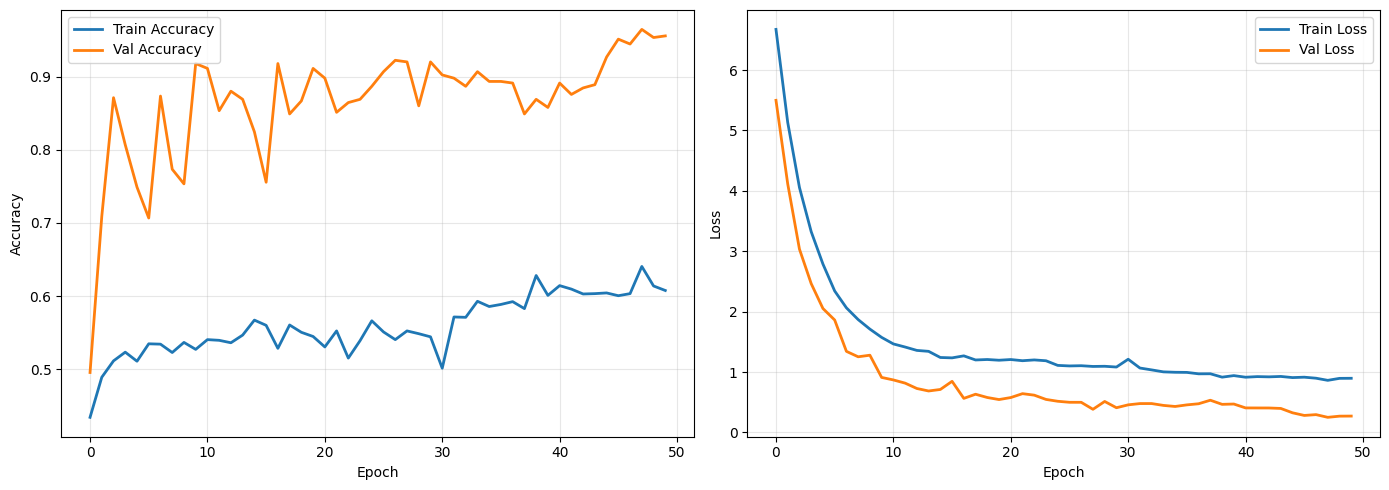

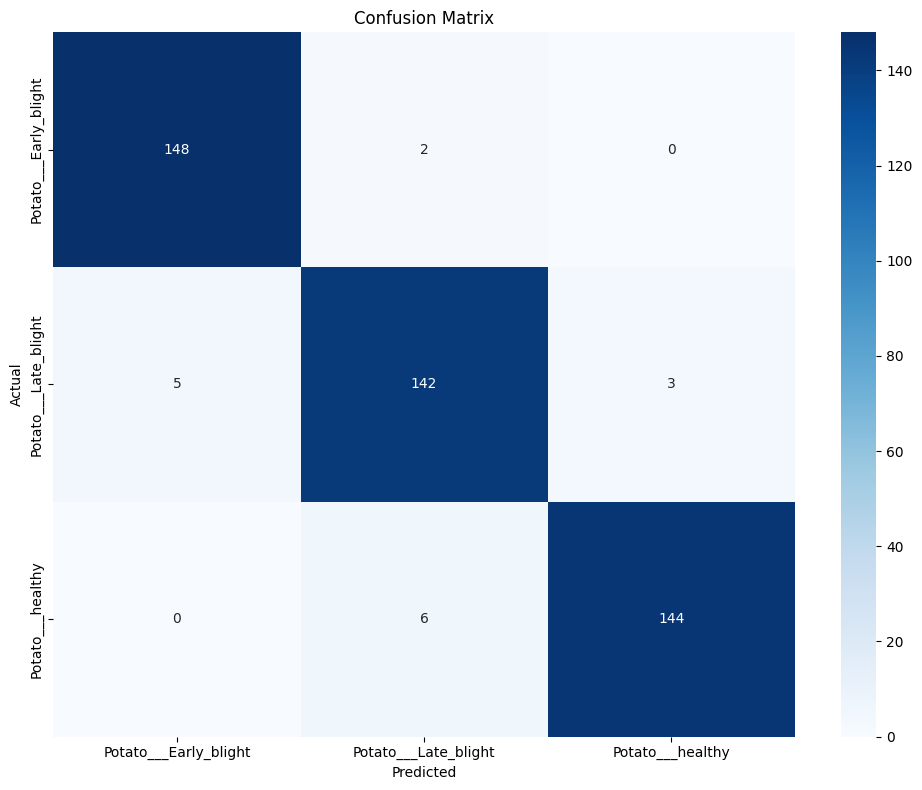

Potato___Early_blight: 98.67%
Potato___Late_blight: 94.67%
Potato___healthy: 96.00%


In [ ]:
# Visualizations
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Training curves
axes[0].plot(history.history['accuracy'], label='Train Accuracy', linewidth=2)
axes[0].plot(history.history['val_accuracy'], label='Val Accuracy', linewidth=2)
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].plot(history.history['loss'], label='Train Loss', linewidth=2)
axes[1].plot(history.history['val_loss'], label='Val Loss', linewidth=2)
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('/content/drive/MyDrive/training_curves.png', dpi=300, bbox_inches='tight')
plt.show()

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.savefig('/content/drive/MyDrive/confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

# Per-class accuracy
for i, class_name in enumerate(CLASS_NAMES):
    class_acc = cm[i, i] / cm[i].sum() * 100 if cm[i].sum() > 0 else 0
    print(f"{class_name}: {class_acc:.2f}%")

In [ ]:
# Export for TensorFlow Serving
import shutil

MODEL_VERSION = 1
EXPORT_BASE = '/content/drive/MyDrive/Minor-project-1/models'
EXPORT_PATH = f'{EXPORT_BASE}/{MODEL_VERSION}'

os.makedirs(EXPORT_PATH, exist_ok=True)

# Save model directly (Keras 3 SavedModel format)
model.export(EXPORT_PATH)

# Save class names
with open(f'{EXPORT_BASE}/class_names.json', 'w') as f:
    json.dump(CLASS_NAMES, f)

# Save comprehensive metrics
metrics = {
    'test_accuracy': float(test_acc),
    'test_loss': float(test_loss),
    'precision': float(precision),
    'recall': float(recall),
    'f1_score': float(f1),
    'total_epochs': len(history.history['accuracy']),
    'phase1_epochs': len(history_phase1.history['accuracy']),
    'phase2_epochs': len(history_phase2.history['accuracy']),
    'image_size': IMG_SIZE,
    'model_architecture': 'MobileNetV2_TransferLearning',
    'classes': CLASS_NAMES,
    'training_date': '2025-12-09'
}

with open(f'{EXPORT_BASE}/metrics.json', 'w') as f:
    json.dump(metrics, f, indent=2)

# Save best checkpoint as backup
shutil.copy('/content/drive/MyDrive/Minor-project-1/checkpoint_phase2.keras',
            f'{EXPORT_BASE}/best_model.keras')

print(f"Model exported successfully")
print(f"Location: {EXPORT_PATH}")
print(f"Test Accuracy: {test_acc*100:.2f}%")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

Saved artifact at '/content/drive/MyDrive/Minor-project-1/models/1'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor_161')
Output Type:
  TensorSpec(shape=(None, 3), dtype=tf.float32, name=None)
Captures:
  134795574064912: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134795574066064: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134795574065488: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134795574066256: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134795574065104: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134795574066448: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134795574773328: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134795574773520: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134795574772752: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134795574772176: TensorSpec(shape=(), dtype=tf.re

In [ ]:
# Package for download
!cd /content/drive/MyDrive/Minor-project-1 && tar -czf potato_production_model.tar.gz models/

print("\nModel packaged successfully")
print("Download from: /content/drive/MyDrive/Minor-project-1/potato_production_model.tar.gz")
print("\nDeployment command:")
print(f"docker run -p 8501:8501 \\")
print(f"  --mount type=bind,source=$(pwd)/models/{MODEL_VERSION},target=/models/potato/{MODEL_VERSION} \\")
print(f"  -e MODEL_NAME=potato -t tensorflow/serving")

tar: models/1/variables/variables.data-00000-of-00001: file changed as we read it
tar: models/1/variables/variables.index: file changed as we read it
tar: models/1/saved_model.pb: file changed as we read it
tar: models/1/fingerprint.pb: file changed as we read it
tar: models/class_names.json: file changed as we read it
tar: models/metrics.json: file changed as we read it
tar: models/best_model.keras: file changed as we read it

Model packaged successfully
Download from: /content/drive/MyDrive/Minor-project-1/potato_production_model.tar.gz

Deployment command:
docker run -p 8501:8501 \
  --mount type=bind,source=$(pwd)/models/1,target=/models/potato/1 \
  -e MODEL_NAME=potato -t tensorflow/serving
